In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

MNIST dataset have images that have size (28,28) therefore we resize them into (32,32). We also Normalize pixels from [0,1] to [-1,1]. We do that so we can get negative gradients. If we had only [0,1] then gradient would always be positive and it would screw with our optimization.

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
BATCH_SIZE = 64
SHUFFLE = True

In [5]:
dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)

In [6]:
data_iter = iter(dataloader)
img, label = next(data_iter)
print(f'Rozmiar obrazków = {img.shape}')
print(f'Rozmiar obrazków = {label.shape}')

Rozmiar obrazków = torch.Size([64, 1, 32, 32])
Rozmiar obrazków = torch.Size([64])


For a sake of simplicity i will hardcode the layers sizes etc

In [7]:
import torch.nn as nn
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.C1 = nn.Conv2d(in_channels = 1,out_channels = 6, kernel_size = (5,5))
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.C3 = nn.Conv2d(in_channels = 6,out_channels = 16, kernel_size = (5,5))
        self.S4 = nn.AvgPool2d(kernel_size = (2,2), stride = 2)
        self.L5 = nn.Linear(400,120)
        self.L6 = nn.Linear(120,84)
        self.Output = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.C1(x)
        x = torch.tanh(x)
        x = self.S2(x)

        x = self.C3(x)
        x = torch.tanh(x)
        x = self.S4(x)

        x = x.view(-1,400)

        x = self.L5(x)
        x = torch.tanh(x)
        x = self.L6(x)
        x = torch.tanh(x)
        x = self.Output(x)
        return x
        
        
        

In [11]:
import torch.optim as optim
model = LeNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [17]:
EPOCHS = 10

In [19]:
for epoch in range (EPOCHS):
    total_loss = 0.0
    for step, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        for p in model.parameters():
            p.grad = None

        pred = model(x_batch)
        loss = loss_function(pred,y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch={epoch} | loss = {avg_loss:.4f}')
            

Epoch=0 | loss = 0.1079
Epoch=1 | loss = 0.0992
Epoch=2 | loss = 0.0917
Epoch=3 | loss = 0.0854
Epoch=4 | loss = 0.0800
Epoch=5 | loss = 0.0752
Epoch=6 | loss = 0.0710
Epoch=7 | loss = 0.0669
Epoch=8 | loss = 0.0639
Epoch=9 | loss = 0.0608


In [21]:
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False,
                                          transform=transform)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=64, 
                         shuffle=False)

In [27]:
def model_eval(loader,model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
    model_eval(test_loader,model)
    acc = 100 * correct / total



    print(f'Dokładność modelu na zbiorze testowym: {acc:.2f}%')

In [28]:
model_eval(test_loader,model)

KeyboardInterrupt: 

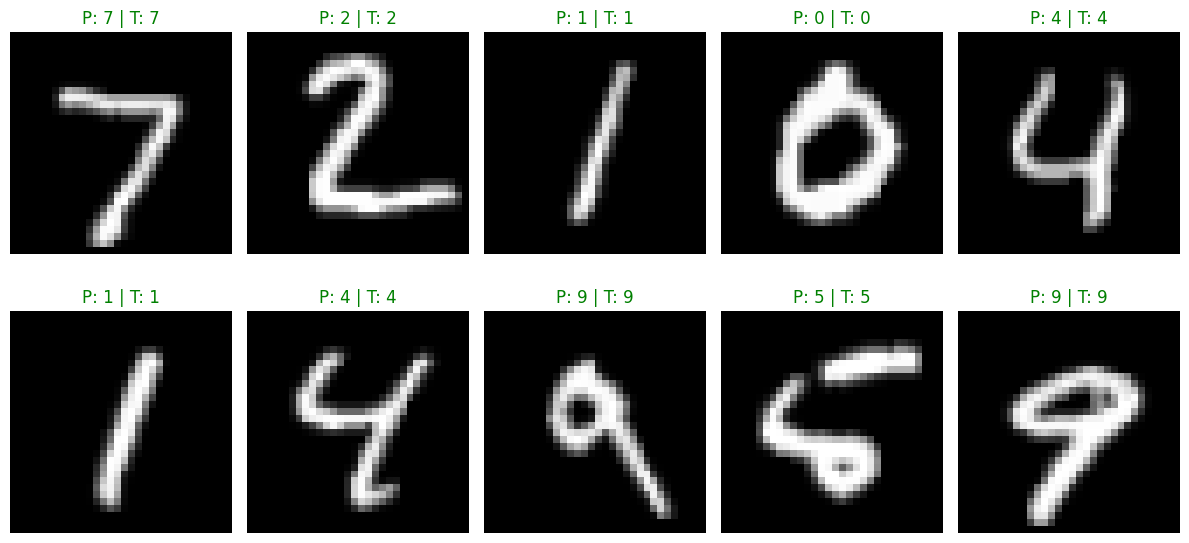

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    images = images.to(device)
    labels = labels.to(device)
    

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()
    rows = 2
    cols = num_images // rows
    fig = plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        ax = fig.add_subplot(rows, cols, i+1)
        img = images[i] / 2 + 0.5 
        img = np.transpose(img.numpy(), (1, 2, 0)) 
        img = img.squeeze() 
        
        ax.imshow(img, cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f"P: {preds[i]} | T: {labels[i]}", color=color)
        ax.axis('off') 
        
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, num_images=10)